In [1]:
import copy
import torch
import numpy as np
import torch_geometric.transforms as T
import matplotlib.pyplot as plt
import importlib
import os
import time
from scipy.spatial.transform import Rotation
from scipy.spatial.distance import cdist
import poisson_modelnet_40
importlib.reload(poisson_modelnet_40)

from poisson_modelnet_40 import (
    get_transform,
    get_rotation_transform,
    get_single_modelnet40_sample
)

# %matplotlib

import pose_estimation
importlib.reload(pose_estimation)
from pose_estimation import ICP, PointCloudMetropolisHastings, nearest_neighbor_src_dst

import tbp.monty.frameworks.environment_utils.transforms
importlib.reload(tbp.monty.frameworks.environment_utils.transforms)
import tbp.monty.frameworks.environments.modelnet
importlib.reload(tbp.monty.frameworks.environments.modelnet)

from tbp.monty.frameworks.environment_utils.transforms import RandomRotate
from tbp.monty.frameworks.utils.metrics import TransformedPointCloudDistance
from tbp.monty.frameworks.environments.modelnet import ModelNet40OnlineOptimization



# Step 1: just see if we can implement ICP or similar.

- Load a single modelnet40 object.
- Sample k points from the mesh.
- Load the same object and apply a known rotation.
- Call pose_estimator(src, tgt)
- Decode the output of pose_estimator so we can compare to known transform
- Examine the fit of the learned transform
- Measure how much time passed
- Extend by replacing error_fn with poisson surface reconstruction

In [2]:
N_SAMPLES = 1024
dst_transform = get_transform(N_SAMPLES)
rot_transform = RandomRotate(axes=["y"])
src_transform = T.Compose([dst_transform, rot_transform])
dataset = ModelNet40OnlineOptimization(
    root=os.path.expanduser("~/tbp/datasets/ModelNet40/raw"),
    transform=None,  # raw torch geometric object
    train=True,
    num_samples_train=2,
    dst_transform=dst_transform,
    src_transform=rot_transform
    )
dataloader = torch.utils.data.DataLoader(dataset, shuffle=True, batch_size=1)

In [3]:
icp = ICP(n_steps=100)

In [4]:
dataset.labels[5]

2

In [5]:
dataset.id_to_object[5]

'monitor'

In [6]:
x0 = dataset.data[5]

In [7]:
x0_dst = dst_transform(x0)

In [8]:
x0_dst.size()

torch.Size([1024, 3])

In [9]:
rotation_matrix = rot_transform.rotation_matrix

In [10]:
src_0 = rot_transform(x0_dst)
src_1 = Rotation.from_matrix(rotation_matrix).apply(x0_dst)
# src_2 = Rotation.from_matrix(rotation_matrix.T).apply(x0_dst)  # see if we were accidentally multiplying by transpose

In [11]:
rt_inv = Rotation.from_matrix(rotation_matrix).inv()
rt_inv_2 = Rotation.from_matrix(rotation_matrix.T).inv()

In [12]:
src_inv = rt_inv.apply(src_0)
src_inv_1 = rt_inv.apply(src_1)
# src_inv_2 = Rotation.from_matrix(rotation_matrix.T).inv().apply(src_0)
src_inv_2 = rt_inv_2.apply(src_0)
dnp = x0_dst.squeeze(0).numpy()

In [13]:
print(rotation_matrix)

tensor([[ 0.5268,  0.0000,  0.8500],
        [ 0.0000,  1.0000,  0.0000],
        [-0.8500,  0.0000,  0.5268]])


In [14]:
src_inv.shape

(1024, 3)

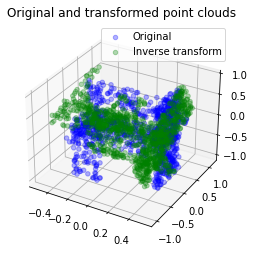

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.set_title("Original and transformed point clouds")

ax.scatter(dnp[:, 1], dnp[:, 0], dnp[:, 2], c="b", alpha=0.3, label="Original")
# ax.scatter(snp[:, 1], snp[:, 0], snp[:, 2], c="r", alpha=0.3, label="Transformed")
ax.scatter(src_inv[:, 1], src_inv[:, 0], src_inv[:, 2], c="g", alpha=0.3, label="Inverse transform")
ax.legend()
# plt.show()

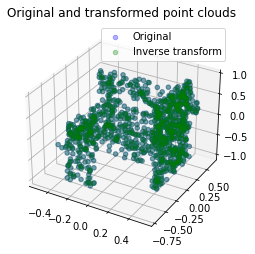

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.set_title("Original and transformed point clouds")

ax.scatter(dnp[:, 1], dnp[:, 0], dnp[:, 2], c="b", alpha=0.3, label="Original")
# ax.scatter(snp[:, 1], snp[:, 0], snp[:, 2], c="r", alpha=0.3, label="Transformed")
ax.scatter(src_inv_1[:, 1], src_inv_1[:, 0], src_inv_1[:, 2], c="g", alpha=0.3, label="Inverse transform")
ax.legend()
# plt.show()

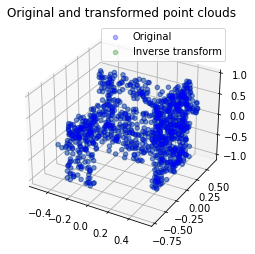

In [17]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.set_title("Original and transformed point clouds")

ax.scatter(dnp[:, 1], dnp[:, 0], dnp[:, 2], c="b", alpha=0.3, label="Original")
# ax.scatter(snp[:, 1], snp[:, 0], snp[:, 2], c="r", alpha=0.3, label="Transformed")
ax.scatter(src_inv_2[:, 1], src_inv_2[:, 0], src_inv_2[:, 2], c="g", alpha=0.3, label="Inverse transform")
ax.legend()
# plt.show()

In [18]:
# src_2 = Rotation.from_matrix(rotation_matrix.T).apply(x0_dst)  # see if we were accidentally multiplying by transpose

src_2 = torch.matmul(x0_dst, rotation_matrix.T)
src_inv_inv = rt_inv.apply(src_2)


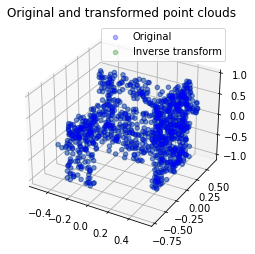

In [19]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.set_title("Original and transformed point clouds")

ax.scatter(dnp[:, 1], dnp[:, 0], dnp[:, 2], c="b", alpha=0.3, label="Original")
# ax.scatter(snp[:, 1], snp[:, 0], snp[:, 2], c="r", alpha=0.3, label="Transformed")
ax.scatter(src_inv_inv[:, 1], src_inv_inv[:, 0], src_inv_inv[:, 2], c="g", alpha=0.3, label="Inverse transform")
ax.legend()
# plt.show()

In [20]:
torch.matmul(rotation_matrix, torch.from_numpy(rt_inv.as_matrix()).float())

tensor([[1.0000e+00, 0.0000e+00, 8.2827e-09],
        [0.0000e+00, 1.0000e+00, 0.0000e+00],
        [8.2827e-09, 0.0000e+00, 1.0000e+00]])

In [21]:
torch.matmul(torch.from_numpy(rt_inv.as_matrix()).float(), rotation_matrix)

tensor([[ 1.0000e+00,  0.0000e+00, -8.2827e-09],
        [ 0.0000e+00,  1.0000e+00,  0.0000e+00],
        [-8.2827e-09,  0.0000e+00,  1.0000e+00]])

In [22]:
x = torch.randn(7)
m = torch.randn(3, 7)
y = torch.matmul(m, x)

In [23]:
y.size()

torch.Size([3])

In [24]:
x0_dst.size()

torch.Size([1024, 3])

In [25]:
x0_dst[0,:]

tensor([-0.5691, -0.2899, -0.9925])

In [26]:
s0 = torch.matmul(rotation_matrix, x0_dst.T)
s1 = torch.matmul(x0_dst, rotation_matrix)

In [27]:
s0.size()

torch.Size([3, 1024])

In [28]:
tinv = torch.inverse(rotation_matrix)

In [29]:
x00 = torch.matmul(tinv, s0)

In [35]:
x00.size()

torch.Size([3, 1024])

In [51]:
xnp = x00.numpy().T
snp2 = s1.numpy()
snp0 = s0.numpy().T

In [52]:
snp0.shape

(1024, 3)

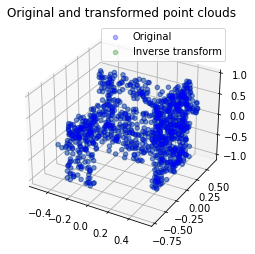

In [53]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.set_title("Original and transformed point clouds")

ax.scatter(dnp[:, 1], dnp[:, 0], dnp[:, 2], c="b", alpha=0.3, label="Original")
# ax.scatter(snp[:, 1], snp[:, 0], snp[:, 2], c="r", alpha=0.3, label="Transformed")
ax.scatter(xnp[:, 1], xnp[:, 0], xnp[:, 2], c="g", alpha=0.3, label="Inverse transform")
ax.legend()
# plt.show()

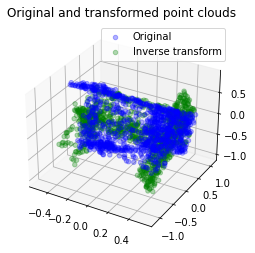

In [55]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.set_title("Original and transformed point clouds")

ax.scatter(snp2[:, 1], snp2[:, 0], snp2[:, 2], c="b", alpha=0.3, label="Original")
# ax.scatter(snp[:, 1], snp[:, 0], snp[:, 2], c="r", alpha=0.3, label="Transformed")
ax.scatter(snp0[:, 1], snp0[:, 0], snp0[:, 2], c="g", alpha=0.3, label="Inverse transform")
ax.legend()
# plt.show()